In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [90]:
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from sklearn.cross_validation import ShuffleSplit, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from util.isoelectric_point import isoelectric_points

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('notebook')

/Users/ericmjl/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We will train a model to predict drug resistance values from sequence.

This is the other general variant of supervised learning - where instead of predicting a "label" for a class (classification), we are predicting a "number" or a "value". This is called "regression", analogous to, say, linear regression or logistic regression.

In [39]:
# Load the sequence data as a Pandas dataframe.

seqids = [s.id for s in SeqIO.parse('data/hiv-protease-sequences-expanded.fasta', 'fasta')]

sequences = [s for s in SeqIO.parse('data/hiv-protease-sequences-expanded.fasta', 'fasta')]
sequences = MultipleSeqAlignment(sequences)
sequences = pd.DataFrame(np.array(sequences))
sequences.index = seqids
# Ensure that all of the letters are upper-case, otherwise the replace function in the next cell won't work.
for col in sequences.columns:
    sequences[col] = sequences[col].apply(lambda x: x.upper())
    sequences[col] = sequences[col].replace('*', np.nan)
sequences.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
2996-0,P,Q,I,T,L,W,Q,R,P,I,...,M,T,Q,L,G,C,T,L,N,F
2996-1,P,Q,I,T,L,W,Q,R,P,I,...,M,T,Q,L,G,C,T,L,N,F
4387-0,P,Q,I,T,L,W,Q,R,P,L,...,L,T,Q,I,G,C,T,L,N,F
4387-1,P,Q,I,T,L,W,Q,R,P,L,...,L,T,Q,I,G,C,T,L,N,F
4387-2,P,Q,I,T,L,W,Q,R,P,L,...,L,T,Q,I,G,C,T,L,N,F


In [40]:
seqdf = sequences.replace(isoelectric_points.keys(), isoelectric_points.values())
seqdf.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
2996-0,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,5.74,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91
2996-1,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,5.74,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91
4387-0,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,6.04,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91
4387-1,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,6.04,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91
4387-2,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,6.04,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91


In [41]:
# Load the drug resistance values
dr_vals = pd.read_csv('data/hiv-protease-data-expanded.csv', index_col=0)
dr_vals.set_index('seqid', inplace=True)
dr_vals.head()

,ATV,DRV,FPV,IDV,LPV,NFV,SQV,SeqID,TPV,sequence,sequence_object,weight
seqid,,,,,,,,,,,,
2996-0,NaN,NaN,2.5,16.3,NaN,38.6,16.1,2996,NaN,PQITLWQRPIVTIKIGGQLKEALLDTGADDTVLEDVNLPGRWKPKM...,ID: 2996-0\nName: <unknown name>\nDescription:...,0.50
2996-1,NaN,NaN,2.5,16.3,NaN,38.6,16.1,2996,NaN,PQITLWQRPIVTIKIGGQLKEALLDTGADDTVLEDVNLPGRWKPKM...,ID: 2996-1\nName: <unknown name>\nDescription:...,0.50
4387-0,NaN,NaN,0.7,0.8,NaN,0.8,1.1,4387,NaN,PQITLWQRPLVTIKVGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,ID: 4387-0\nName: <unknown name>\nDescription:...,0.25
4387-1,NaN,NaN,0.7,0.8,NaN,0.8,1.1,4387,NaN,PQITLWQRPLVTIKVGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,ID: 4387-1\nName: <unknown name>\nDescription:...,0.25
4387-2,NaN,NaN,0.7,0.8,NaN,0.8,1.1,4387,NaN,PQITLWQRPLVTIKVGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,ID: 4387-2\nName: <unknown name>\nDescription:...,0.25


In [42]:
# Join the sequence data together with that of one drug of interest.
drug_name = 'FPV'

data_matrix = seqdf.join(dr_vals[drug_name]).dropna()  # we have to drop NaN values because scikit-learn algorithms are not designed to accept them.
data_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,FPV
2996-0,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91,2.5
2996-1,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91,2.5
4387-0,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91,0.7
4387-1,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91,0.7
4387-2,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91,0.7


## Exercise

Practice what you've learned! Split the data into features, response variable, and then do a train/test split.

In [43]:
# Answer

X = data_matrix[[i for i in range(99)]]
Y = data_matrix[drug_name]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Exercise

Now, let's train the Random Forest Regressor on the data.

In [44]:
# Answer

mdl1 = RandomForestRegressor()
mdl1.fit(X_train, Y_train)
preds1 = mdl1.predict(X_test)

Let's now examine what the preds look like

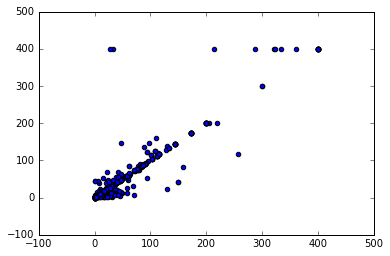

In [49]:
plt.scatter(preds1, Y_test)

## Evaluating the Model

Just as with classification tasks, we also need metrics to help evaluate how good a trained model is, given the input features.

## Exercise

Look through the [`sklearn.metrics`][1] module. What might be a suitable metric to use?

Justify the use of two of them, and write the code that computes the evaluation metric.

[1]: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [51]:
# Metric 1: correlation coefficient.
r2_score(preds1, Y_test)  # this is provided in the sklearn.metrics module.

0.8811193971461645

In [53]:
# Metric 2: mean squared error
mean_squared_error(preds1, Y_test)

349.48292381717306

### Discussion

What does the distribution of values look like? Where is its skew? How could we tell?

What would be a better way of transforming the data prior to doing ML?

## Live-Coding

Let's try log10-transforming the values to be predicted. 

In [57]:
X = data_matrix[[i for i in range(99)]]
Y = data_matrix[drug_name].apply(lambda x: np.log10(x))

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

mdl = RandomForestRegressor()
mdl.fit(X_train, Y_train)
preds = mdl.predict(X_test)

mean_squared_error(preds, Y_test)

0.0366541157391038

Note: the MSE goes down because of the `log10` transform. However, that's exactly what we would have expected by definition.

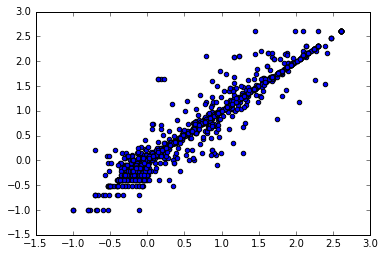

In [61]:
plt.scatter(preds, Y_test)

In [62]:
r2_score(preds, Y_test) 

0.94291909136728558

## Challenge Exercise

Can you compare the following algorithms to see which one performs best?

- `RandomForestRegressor`
- `GradientBoostingRegressor`
- `AdaBoostRegressor`
- `ExtraTreesRegressor`

## Live Coding: Statistical Practices

Feel free to type along!

In [81]:
cv = ShuffleSplit(n=len(X), n_iter=10, test_size=0.3)

models = dict()
models['rf'] = RandomForestRegressor()
models['gb'] = GradientBoostingRegressor()
models['ad'] = AdaBoostRegressor()
models['ex'] = ExtraTreesRegressor()

scores = dict()

for abbr, model in models.items():
    print(abbr, model)
    score = cross_val_score(model, X, Y, cv=cv, scoring='mean_squared_error')
    scores[abbr] = -score

ex ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
rf RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
gb GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)
ad AdaBoostRegressor(

/Users/ericmjl/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


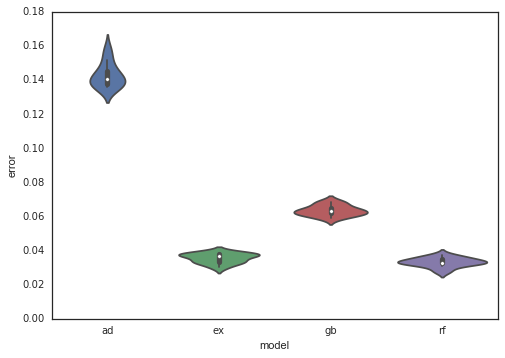

In [104]:
score_summary = pd.DataFrame(scores)
score_summary = pd.DataFrame(score_summary.unstack()).reset_index()
# sns.violinplot(x=)
score_summary.columns = ['model', 'idx', 'error']
sns.violinplot(x='model', y='error', data=score_summary)

Statistical good practices:

1. Train/test split
2. Shuffle your data, to break up any inadvertant structure in the dataset.
3. Compare different models in a systematic way.